# **Import Required Modules**

In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

from tqdm import tqdm
import os

import warnings
warnings.filterwarnings('ignore')

# **Dataset Preparation**

## **Fetching the Dataset**

In [9]:
class TinyImageNetDataset(Dataset):
    def __init__(self, dataset_dir, split='train', images_per_class=100, selected_classes=None, transform=None):
        assert split in ['train', 'val'], "split must be 'train' or 'val'"
        self.dataset_dir = dataset_dir
        self.split = split
        self.images_per_class = images_per_class
        self.selected_classes = selected_classes
        self.transform = transform

        if split == 'train':
            self.data = self.load_train_data()
        elif split == 'val':
            self.data = self.load_val_data()

    def load_train_data(self):
        train_data = []
        for label_dir in os.listdir(os.path.join(self.dataset_dir, 'train')):
            class_id = label_dir
            if self.selected_classes is not None and class_id not in self.selected_classes:
                continue
            class_dir = os.path.join(self.dataset_dir, 'train', label_dir, 'images')
            class_images = os.listdir(class_dir)[:self.images_per_class]
            for image_file in class_images:
                image_path = os.path.join(class_dir, image_file)
                train_data.append((image_path, class_id))
        return train_data

    def load_val_data(self):
        val_data = []
        with open(os.path.join(self.dataset_dir, 'val', 'val_annotations.txt'), 'r') as f:
            val_annotations = f.readlines()
        class_counts = {}
        for line in val_annotations:
            image_file, class_id = line.strip().split('\t')[:2]
            if self.selected_classes is not None and class_id not in self.selected_classes:
                continue
            class_dir = os.path.join(self.dataset_dir, 'val', 'images', image_file)
            val_data.append((class_dir, class_id))
        return val_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, class_id = self.data[idx]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        class_id = int(class_id[1:])  # Convert class ID to integer
        return image, class_id


In [10]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

batch_size = 128
dataset_dir = '/kaggle/input/imagenet-tiny/tiny-imagenet-200'
selected_classes = ['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 
                    'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750']

train_dataset = TinyImageNetDataset(dataset_dir, split='train', images_per_class=5000, selected_classes=selected_classes, transform=train_transform)
val_dataset = TinyImageNetDataset(dataset_dir, split='val', images_per_class=500, selected_classes=selected_classes, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

In [11]:
def print_dataloader_info(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    print(f"Batch size: {images.shape[0]}")
    print(f"Image shape: {images.shape[1:]}")
    
    if labels is not None:
        if isinstance(labels, str):
            labels = [labels] 
        if isinstance(labels[0], str):  # Check if labels are provided as strings
            num_classes = len(torch.unique(torch.tensor([int(label[1:]) for label in labels])))  # Convert labels to integers
            print(f"Number of classes: {num_classes}")
        else:
            print(f"Number of classes: {len(torch.unique(labels))}")
    else:
        print("Labels are not available.")

print("Train Dataset:")
print_dataloader_info(train_loader)
print()

print("Validation Dataset:")
print_dataloader_info(val_loader)


Train Dataset:
Batch size: 128
Image shape: torch.Size([3, 64, 64])
Number of classes: 10

Validation Dataset:
Batch size: 128
Image shape: torch.Size([3, 64, 64])
Number of classes: 10


# **Training Process**

## **Defining AlexNet using Pytorch**

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),  
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))  
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


## **Defining the Training Loop**

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_labels = []
for data in train_loader:
    _, labels = data
    all_labels.extend(labels)

for data in val_loader:
    _, labels = data
    all_labels.extend(labels)

label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

alexnet_imagenet = AlexNet(num_classes=10).to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for data parallelism.")
    alexnet_imagenet = nn.DataParallel(alexnet_imagenet)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_imagenet.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
torch.nn.utils.clip_grad_norm_(alexnet_imagenet.parameters(), max_norm=1)
torch.backends.cudnn.benchmark = True

epochs = 10

train_loss_history = []
train_accuracy_history = []
test_loss_history = []
test_accuracy_history = []

for epoch in range(epochs):
    running_loss = 0.0
    running_correct = 0.0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") 
    for i, data in enumerate(pbar, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = label_encoder.transform(labels)  
        labels = torch.tensor(labels).to(device) 
        optimizer.zero_grad()
        outputs = alexnet_imagenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        accuracy = torch.sum(predicted == labels.to(device)).item() / labels.size(0)
        pbar.set_postfix(loss=running_loss / (i + 1), accuracy=accuracy)

    scheduler.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = (running_correct / total) * 100
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)

    test_running_loss = 0.0
    test_running_correct = 0.0
    test_total = 0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            labels = label_encoder.transform(labels) 
            labels = torch.tensor(labels).to(device)  
            inputs = inputs.to(device) 
            outputs = alexnet_imagenet(inputs)
            loss = criterion(outputs, labels)

            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_running_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(val_loader)
    test_accuracy = (test_running_correct / test_total) * 100
    test_loss_history.append(test_loss)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Train Accuracy: {train_accuracy:.2f}% - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.2f}%')

print('Finished Training')


Using 2 GPUs for data parallelism.


Epoch 1/10: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s, accuracy=0.25, loss=2.12] 


Epoch 1/10 - Train Loss: 2.1241 - Train Accuracy: 22.70% - Test Loss: 2.1376 - Test Accuracy: 23.60%


Epoch 2/10: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s, accuracy=0.125, loss=1.98]


Epoch 2/10 - Train Loss: 1.9781 - Train Accuracy: 28.94% - Test Loss: 1.8978 - Test Accuracy: 31.80%


Epoch 3/10: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, accuracy=0.25, loss=1.86] 


Epoch 3/10 - Train Loss: 1.8615 - Train Accuracy: 34.10% - Test Loss: 1.8157 - Test Accuracy: 35.20%


Epoch 4/10: 100%|██████████| 40/40 [00:08<00:00,  4.59it/s, accuracy=0.25, loss=1.84] 


Epoch 4/10 - Train Loss: 1.8431 - Train Accuracy: 34.54% - Test Loss: 1.8514 - Test Accuracy: 35.00%


Epoch 5/10: 100%|██████████| 40/40 [00:08<00:00,  4.60it/s, accuracy=0.5, loss=1.79]  


Epoch 5/10 - Train Loss: 1.7884 - Train Accuracy: 36.38% - Test Loss: 1.7582 - Test Accuracy: 38.20%


Epoch 6/10: 100%|██████████| 40/40 [00:08<00:00,  4.55it/s, accuracy=0.375, loss=1.68]


Epoch 6/10 - Train Loss: 1.6773 - Train Accuracy: 41.38% - Test Loss: 1.6756 - Test Accuracy: 41.20%


Epoch 7/10: 100%|██████████| 40/40 [00:08<00:00,  4.57it/s, accuracy=0.25, loss=1.64] 


Epoch 7/10 - Train Loss: 1.6433 - Train Accuracy: 41.82% - Test Loss: 1.6535 - Test Accuracy: 41.00%


Epoch 8/10: 100%|██████████| 40/40 [00:08<00:00,  4.64it/s, accuracy=0.25, loss=1.63] 


Epoch 8/10 - Train Loss: 1.6324 - Train Accuracy: 42.72% - Test Loss: 1.6493 - Test Accuracy: 40.80%


Epoch 9/10: 100%|██████████| 40/40 [00:08<00:00,  4.58it/s, accuracy=0.75, loss=1.59] 


Epoch 9/10 - Train Loss: 1.5857 - Train Accuracy: 43.50% - Test Loss: 1.6373 - Test Accuracy: 41.60%


Epoch 10/10: 100%|██████████| 40/40 [00:08<00:00,  4.61it/s, accuracy=0.625, loss=1.58]


Epoch 10/10 - Train Loss: 1.5824 - Train Accuracy: 44.20% - Test Loss: 1.6285 - Test Accuracy: 41.20%
Finished Training


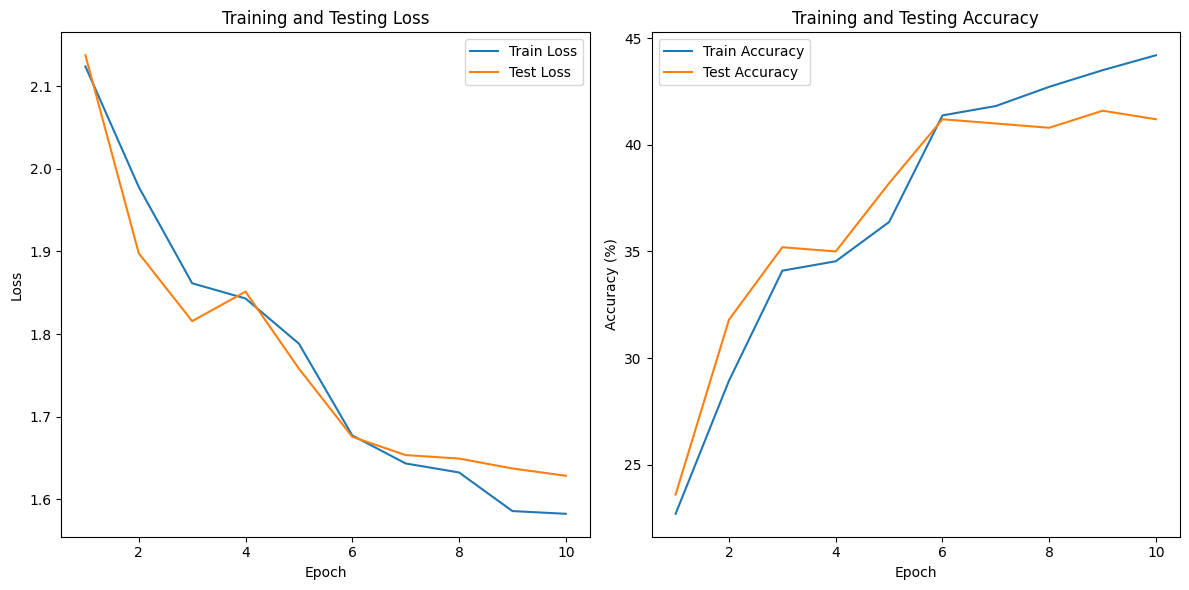

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].plot(range(1, epochs + 1), train_loss_history, label='Train Loss')
axs[0].plot(range(1, epochs + 1), test_loss_history, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training and Testing Loss')
axs[0].legend()

axs[1].plot(range(1, epochs + 1), train_accuracy_history, label='Train Accuracy')
axs[1].plot(range(1, epochs + 1), test_accuracy_history, label='Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].set_title('Training and Testing Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()
